In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export 
from exp.nb_04 import *

# Initial setup

In [4]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [5]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [6]:
#export
def create_learner(model_func, loss_func, data):
    '''learner put everything inside and initialize it'''
    return Learner(*model_func(data), loss_func, data)

In [7]:
learn = create_learner(get_model, loss_func, data)
# runner can call fit directly
run = Runner([AvgStatsCallback([accuracy])])
run.fit(3, learn)

train : [0.65361328125, tensor(0.8085)]
valid : [0.3178686767578125, tensor(0.9083)]
train : [0.302593671875, tensor(0.9117)]
valid : [0.244074755859375, tensor(0.9284)]
train : [0.24341068359375, tensor(0.9291)]
valid : [0.235284228515625, tensor(0.9323)]


In [8]:
#export 
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

# Annealing
2 new callbacks:

1. Recorder to save track of the loss and our scheduled learning rate

2. ParamScheduler can schedule any hyperparameter as long s it's registered in the state_dict of optimizer

In [9]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        # append lr and losses
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order = 1 
    def __init__(self, pname, sched_func): 
        self.pname, self.sched_func = pname, sched_func

    def set_param(self):
        # set the schedule of parameter
        for pg in self.opt.param_groups:
            # sched_func(current %)
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        # if train, set param
        if self.in_train: self.set_param()

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end - start)
    return partial(_inner, start, end) # only take position

version of only decorator

In [11]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

# decorator is a function that returns a function
# pass sched_lin into annealer function
@annealer
def sched_lin(start, end, pos): return start + pos * (end - start)

In [12]:
f = sched_lin(1, 2)
f(0.3)

1.3

other scheduler functinos

In [13]:
#export

@annealer
def sched_cos(start, end, pos):
    return start + (1+math.cos(math.pi*(1-pos))) * (end-start)/ 2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/ start) ** pos

# this monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

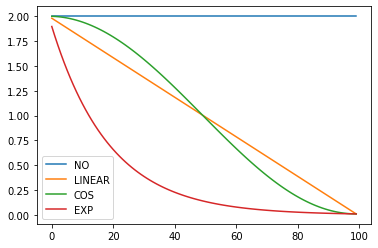

In [14]:
annealings = "NO LINEAR COS EXP".split()
a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
# for every annealer
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    # for every linspace
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

in practice we'll often combine different schedulers
scheds[i] for pcts[i]

In [15]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    # 0.2, 0.8
    pcts = tensor([0]+ listify(pcts))
    
    assert torch.all(pcts>=0)
    # pcts = 0.2, 1
    pcts = torch.cumsum(pcts, 0)
    
    def _inner(pos):
        # current position in pcts
        idx = (pos >= pcts).nonzero().max()
        # actual position in the pcts
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [17]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
# 30% cos 70% cos

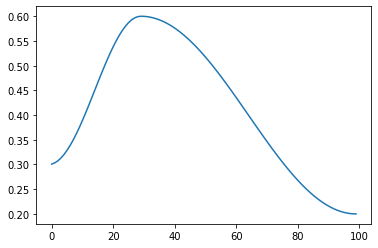

In [18]:
plt.plot(a, [sched(o) for o in p])

In [19]:
cbfs = [Recorder, 
       partial(AvgStatsCallback, accuracy),
       partial(ParamScheduler, 'lr', sched)]

In [20]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs = cbfs)

In [21]:
run.fit(3, learn)

train : [0.799946328125, tensor(0.7780)]
valid : [0.5383845703125, tensor(0.8219)]
train : [0.3098480859375, tensor(0.9085)]
valid : [0.2397388671875, tensor(0.9318)]
train : [0.24359228515625, tensor(0.9305)]
valid : [0.2164303466796875, tensor(0.9386)]


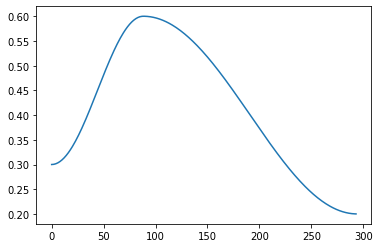

In [22]:
run.recorder.plot_lr()

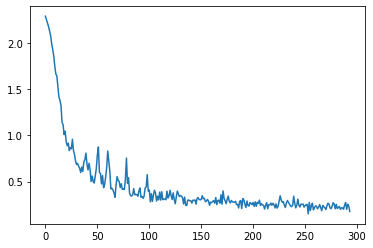

In [23]:
run.recorder.plot_loss()

# Export

In [24]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
